In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import  SGD
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Define the path to your original dataset and the paths where you want to store your train and test datasets
original_dataset_dir = 'CK+'
train_dir = 'CK+train'
validate_dir = 'CK+validate'
test_dir = 'CK+test'

# Create directories for training and testing datasets if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validate_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio
train_ratio = 0.7

# Loop through each emotion category in the original dataset
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Get a list of all the image filenames in the emotion category
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]

        # Randomly shuffle the list of image filenames
        np.random.shuffle(images)

        # Split the list of image filenames into training and testing sets
        train_size = int(len(images) * train_ratio)
        validate_size = int(len(images)-len(images)*(15/100))
        train_images = images[:train_size]
        validate_images = images[train_size:validate_size]
        test_images = images[validate_size:]

        # Create directories for the emotion category in the train and test datasets
        train_emotion_dir = os.path.join(train_dir, emotion)
        validate_emotion_dir = os.path.join(validate_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(validate_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)

        # Copy the images into the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in validate_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(validate_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


In [ ]:
# Create a data generator with augmentation
trainDataGenerator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values (normalization)
    width_shift_range=0.1,  # Random horizontal shifts (10% of total width)
    height_shift_range=0.1,  # Random vertical shifts (10% of total height)
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',
    zoom_range=0.1,
    shear_range=0.1,
)

# Load images from the directory and apply the defined transformations
trainingData = trainDataGenerator.flow_from_directory(
    'CK+train',  # Path to the training data
    target_size=(48, 48),  # Resize images to 48x48
    class_mode='categorical',  # Labels will be returned in categorical format
    batch_size=8
)

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(trainingData.labels), y = trainingData.labels)
class_weight_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

Found 682 images belonging to 7 classes.


In [ ]:
# Initialize an ImageDataGenerator for test data with rescaling
validationDataGenerator = ImageDataGenerator(rescale=1./255,  # Rescale the pixel values (normalization)
)
# Creates a data generator for the test dataset
# flow_from_directory method loads images from a directory
validationData = validationDataGenerator.flow_from_directory(
    'CK+validate',  # Directory path for test images
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    class_mode = 'categorical',  # Images are classified categorically
    batch_size=8
)

# validationData is now a generator that yields batches of test images and their labels
validationData.class_indices

Found 147 images belonging to 7 classes.


{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sadness': 5,
 'surprise': 6}

In [ ]:
testDataGenerator = ImageDataGenerator(rescale=1./255)

testingData = testDataGenerator.flow_from_directory(
    'CK+test',  # Directory path for test images
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    class_mode = 'categorical',  # Images are classified categorically
    batch_size=8,
    shuffle = False,
)

testingData.class_indices

Found 152 images belonging to 7 classes.


{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sadness': 5,
 'surprise': 6}

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding="same",input_shape=(48,48,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

opts = SGD(
    learning_rate=0.01, nesterov=True
)
model.compile(optimizer=opts,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_184 (Conv2D)         (None, 48, 48, 32)        896       
                                                                 
 conv2d_185 (Conv2D)         (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_100 (MaxPool  (None, 23, 23, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_186 (Conv2D)         (None, 21, 21, 64)        18496     
                                                                 
 conv2d_187 (Conv2D)         (None, 19, 19, 64)        36928     
                                                                 
 max_pooling2d_101 (MaxPool  (None, 9, 9, 64)          0         
 ing2D)                                              

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.5,
    patience=5,
    min_lr=0.0000001,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

history = model.fit(
    trainingData,
    epochs=256,
    validation_data=validationData,
    callbacks=callbacks,
    class_weight=class_weight_dict
)
model.save('FER1.keras')


Epoch 1/256
85/85 [==============================] - 2s 7ms/step - loss: 1.9563 - accuracy: 0.1543 - val_loss: 1.9593 - val_accuracy: 0.2109 - lr: 0.0100
Epoch 2/256
85/85 [==============================] - 1s 6ms/step - loss: 1.9469 - accuracy: 0.1217 - val_loss: 1.9437 - val_accuracy: 0.1224 - lr: 0.0100
Epoch 3/256
85/85 [==============================] - 1s 6ms/step - loss: 1.9379 - accuracy: 0.1513 - val_loss: 1.9299 - val_accuracy: 0.2177 - lr: 0.0100
Epoch 4/256
85/85 [==============================] - 0s 6ms/step - loss: 1.9547 - accuracy: 0.1691 - val_loss: 1.9538 - val_accuracy: 0.1905 - lr: 0.0100
Epoch 5/256
85/85 [==============================] - 1s 6ms/step - loss: 1.9550 - accuracy: 0.1439 - val_loss: 1.9511 - val_accuracy: 0.0748 - lr: 0.0100
Epoch 6/256
85/85 [==============================] - 1s 6ms/step - loss: 1.9409 - accuracy: 0.2136 - val_loss: 1.9228 - val_accuracy: 0.2109 - lr: 0.0100
Epoch 7/256
85/85 [==============================] - 1s 6ms/step - loss: 1.9

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()


19/19 [==============================] - 0s 2ms/step - loss: 0.1938 - accuracy: 0.9605
final train accuracy = 97.07 , validation accuracy = 97.96
19/19 [==============================] - 0s 2ms/step


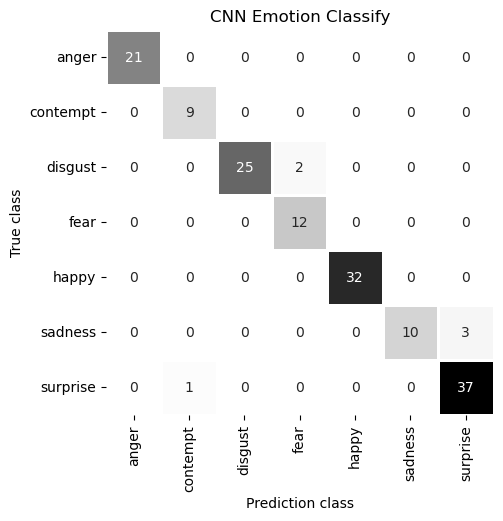

In [ ]:
train_loss, train_accu = model.evaluate(trainingData)
val_loss, val_accu = model.evaluate(validationData)
test_loss, test_accu = model.evaluate(testingData)

print("final train accuracy = {:.2f}, validation accuracy = {:.2f}, testing accuracy = {:.2f}"
      .format(train_accu*100, val_accu*100, test_accu*100))

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np



Y_pred = model.predict(testingData)
y_pred = np.argmax(Y_pred, axis=1)

label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
labels = {0 : 'anger', 1 : 'contempt', 2 : 'disgust', 3 : 'fear', 4 : 'happy',5 :'sadness',6 :'surprise'}

#Transform to df for easier plotting
cm = confusion_matrix(testingData.classes, y_pred)
cm_df = pd.DataFrame(cm, index = label,
                     columns = label
                    )

import seaborn as sns

plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

1/1 [==============================] - 0s 14ms/step


Text(0.5, 1.0, 'anger')

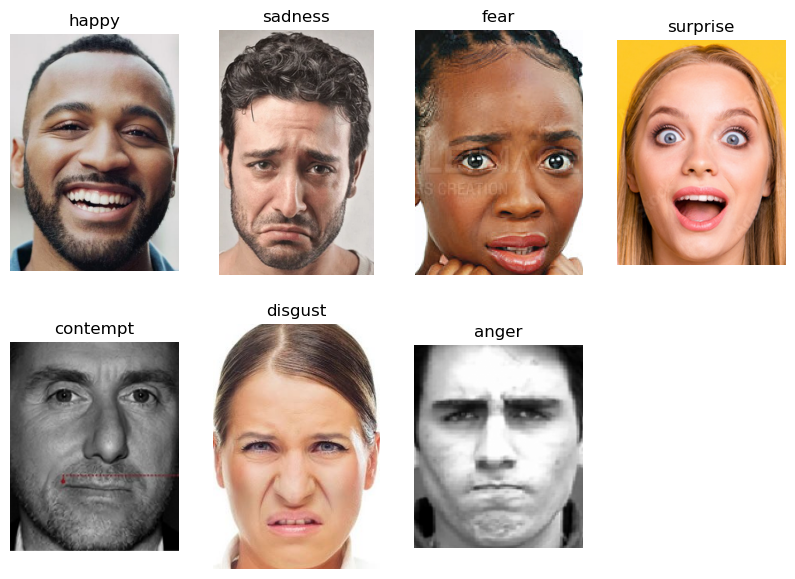

In [ ]:
from keras.utils import load_img

def choose_image_and_predict(image):
    img  = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img/255
    img = np.expand_dims(img, axis=0)
    img = np.stack([img] * 3, axis=-1)
    pred = model.predict(img)
    label=np.argmax(pred,axis=1)[0]
    return labels[label]


fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(load_img("happy.jpg"))
plt.axis('off')
plt.title(choose_image_and_predict("happy.jpg"))

fig.add_subplot(rows, columns, 2)
plt.imshow(load_img("sad.png"))
plt.axis('off')
plt.title(choose_image_and_predict("sad.png"))

fig.add_subplot(rows, columns, 3)
plt.imshow(load_img("fear2.png"))
plt.axis('off')
plt.title(choose_image_and_predict("fear2.png"))


fig.add_subplot(rows, columns, 4)
plt.imshow(load_img("surprise.png"))
plt.axis('off')
plt.title(choose_image_and_predict("surprise.png"))


fig.add_subplot(rows, columns, 5)
plt.imshow(load_img("contempt.png"))
plt.axis('off')
plt.title(choose_image_and_predict("contempt.png"))

fig.add_subplot(rows, columns, 6)
plt.imshow(load_img("disgust.png"))
plt.axis('off')
plt.title(choose_image_and_predict("disgust.png"))

fig.add_subplot(rows, columns, 7)
plt.imshow(load_img("anger.png"))
plt.axis('off')
plt.title(choose_image_and_predict("anger.png"))